### Test the Model (Competition)

In [1]:
# import the required packages
# Core
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP
import nltk
from nltk import pos_tag
from nltk import ne_chunk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

# Machine Learning - Preprocessing & Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# Machine Learning - Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Association Rule Mining
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from unidecode import unidecode
from mlxtend.preprocessing import TransactionEncoder


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Admin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
df = pd.read_csv('AA_movie_train_data.csv')

In [81]:
movie_genre = list(df['Genre'].unique())
movie_genre.sort()
movie_genre

['action', 'comedy', 'documentary', 'drama', 'thriller']

In [82]:
genre_mapper = {'action': 0, 'documentary': 1, 'comedy':2, 'drama':3,  'thriller': 4}
df['Genre'] = df['Genre'].map(genre_mapper)
df.head(10)

,Title,Genre,Description
0,Windup (2006),0,Windup is a very original comedy. We follow B...
1,Hitman (2014),0,"Rana and Shuvo, two siblings, are very differ..."
2,Taken by Force (2010),0,When a San Francisco detective goes hunting f...
3,Bui doi Cho Lon (2013),0,"A man name Lam picks up his girlfriend, but i..."
4,Siam Yuth: The Dawn of the Kingdom (2015),0,Thap and Sin are a homeless musician brothers...
5,Ninja Champion (1986),0,A couple camping in the woods is attacked by ...
6,ISIS: Enemies of Humanity (2017),0,ISIS Enemies of Humanity is an upcoming Inter...
7,Veerta (1993),0,Multi-millionaire Balwant Rai is a widower wh...
8,Cherry Bomb (2011),0,In homage to the action films of the early 19...
9,Lai Bhaari (2014),0,Pratapsingh Nimbalkar and his wife Sumitra ar...


In [83]:
df.isna().any()

Title          False
Genre          False
Description    False
dtype: bool

In [84]:
df.shape

(5000, 3)

In [85]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode

# Ensure necessary NLTK datasets are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# 🔹 1. Helper functions from SCRIPT 1

def get_stop_words(stop_file_path, include_spanish=True):
    with open(stop_file_path, 'r', encoding='utf-8') as f:
        custom_stopwords = set(line.strip().lower() for line in f if line.strip())
    
    if include_spanish:
        spanish_stopwords = set(nltk_stopwords.words('spanish'))
        custom_stopwords.update(spanish_stopwords)
    
    return frozenset(custom_stopwords)

def clean_text(text):
    text = unidecode(text)                     # strip accents
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r"</?.*?>", " ", text)
    text = re.sub(r"(\d|\W|_)+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_text(text):
    return word_tokenize(text)

def get_wordnet_pos(treebank_tag):
    """Convert TreeBank POS tags to WordNet POS tags"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatize_with_pos(pos_tagged_tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    
    for word, tag in pos_tagged_tokens:
        pos = get_wordnet_pos(tag)  # You already have this function
        lemma = lemmatizer.lemmatize(word, pos)
        lemmas.append(lemma)

    return lemmas

# 🔹 2. Full text processing pipeline function from SCRIPT 1
def full_text_pipeline(text, stopwords):
    cleaned = clean_text(text)
    tokens = tokenize_text(cleaned)
    pos_tags = pos_tag(tokens)
    lemmas = lemmatize_with_pos(pos_tags)
    filtered = [lemma for lemma in lemmas if lemma not in stopwords]
    return filtered, ' '.join(filtered)

# 🔹 3. Custom stopwords (adjust this with your actual path to stopwords file)
stopwords = get_stop_words("stopwords.txt", include_spanish=True)

# 🔹 4. Full processing for dataframe (from SCRIPT 2, with custom stopwords and lemmatization)
corpus = []

# Iterate through each row of the DataFrame
for i in range(0, df.shape[0]):
    # Get the current text (dialog/script)
    dialog = df['Description'][i]
    
    # Apply full text pipeline (cleaning, tokenization, lemmatization, and stopwords removal)
    filtered_tokens, filtered_string = full_text_pipeline(dialog, stopwords)
    
    # Store the cleaned and processed text
    corpus.append(filtered_string)

# Add the processed corpus back to the DataFrame if needed
df['processed_text'] = corpus

# Optionally, you can save the results to a CSV
df[['processed_text']].to_csv('processed_dialog.csv', index=False)

# This should give you the processed text, cleaned, lemmatized, and stopword-free.


[nltk_data] Downloading package punkt to C:\Users\Admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [73]:
# Required Libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1️⃣ Encode the labels (genres)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Genre'])  # Genre → numeric

# 2️⃣ Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['processed_text'].tolist(), 
    df['label'].tolist(), 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']
)

# 3️⃣ Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

# 4️⃣ Create PyTorch Datasets
class MovieDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = MovieDataset(train_encodings, train_labels)
val_dataset = MovieDataset(val_encodings, val_labels)

# 5️⃣ Model initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model.to(device)

# 6️⃣ Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# 7️⃣ Training loop
model.train()
for epoch in range(num_epochs):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

# 8️⃣ Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# 9️⃣ Metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
print("F1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))


Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]c:\Users\Admin\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating: 100%|██████████| 63/63 [01:22<00:00,  1.31s/it]
c:\Users\Admin\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Admin\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Co


Classification Report:


TypeError: object of type 'numpy.int64' has no len()

In [76]:
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))


              precision    recall  f1-score   support

           0     0.7688    0.7650    0.7669       200
           1     0.8300    0.8300    0.8300       200
           2     0.7840    0.6350    0.7017       200
           3     0.6129    0.6650    0.6379       200
           4     0.6982    0.7750    0.7346       200

    accuracy                         0.7340      1000
   macro avg     0.7388    0.7340    0.7342      1000
weighted avg     0.7388    0.7340    0.7342      1000



In [ ]:
# Required Libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Encode the labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Genre'])

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['processed_text'].tolist(), 
    df['label'].tolist(), 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']
)

# Tokenization using RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

# PyTorch Dataset
class MovieDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = MovieDataset(train_encodings, train_labels)
val_dataset = MovieDataset(val_encodings, val_labels)

# Model initialization
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
model.to(device)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Training loop
model.train()
for epoch in range(num_epochs):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Metrics
print("\nClassification Report:")
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))
print("F1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))


Using device: cpu


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\Admin\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]c:\Users\Admin\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating: 100%|██████████| 63/63 [01:21<00:00,  1.30s/it]


Classification Report:


TypeError: object of type 'numpy.int64' has no len()

In [91]:
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))


              precision    recall  f1-score   support

           0     0.7346    0.7750    0.7543       200
           1     0.8912    0.8600    0.8753       200
           2     0.8225    0.6950    0.7534       200
           3     0.6261    0.7200    0.6698       200
           4     0.7614    0.7500    0.7557       200

    accuracy                         0.7600      1000
   macro avg     0.7672    0.7600    0.7617      1000
weighted avg     0.7672    0.7600    0.7617      1000



In [90]:
# Required Libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Encode the labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Genre'])

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['processed_text'].tolist(), 
    df['label'].tolist(), 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']
)

# Load ELECTRA tokenizer and model
model_name = "google/electra-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)
)
model.to(device)

# Tokenize the text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

# PyTorch Dataset
class MovieDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = MovieDataset(train_encodings, train_labels)
val_dataset = MovieDataset(val_encodings, val_labels)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Training loop
model.train()
for epoch in range(num_epochs):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Metrics
print("\nClassification Report:")
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))
print("F1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))


Using device: cpu


ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

In [19]:
corpus[0:10]

['windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gr

In [20]:
len(corpus)

5000

In [21]:
action_words = []
for i in list(df[df['Genre']==0].index):
  action_words.append(corpus[i])

documentary_words = []
for i in list(df[df['Genre']==1].index):
  documentary_words.append(corpus[i])

comedy_words = []
for i in list(df[df['Genre']==2].index):
  comedy_words.append(corpus[i])

drama_words = []
for i in list(df[df['Genre']==3].index):
  drama_words.append(corpus[i])

thriller_words = []
for i in list(df[df['Genre']==4].index):
  thriller_words.append(corpus[i])

action = ''
documentary = ''
comedy = ''
drama = ''
thriller = ''

for i in range(0, 4):
  action += action_words[i]
  documentary += documentary_words[i]
  comedy += comedy_words[i]
  drama += drama_words[i]
  thriller += thriller_words[i]

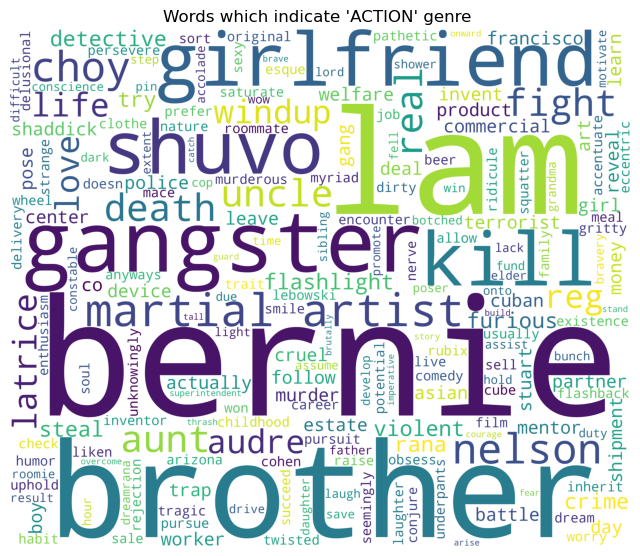

In [25]:
from wordcloud import WordCloud
wordcloud1 = WordCloud(background_color='white', width=3000, height=2500).generate(action)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title("Words which indicate 'ACTION' genre ")
plt.show()

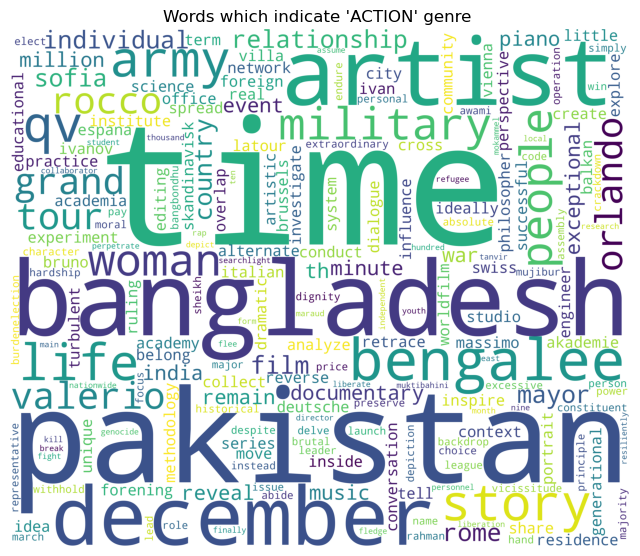

In [24]:
from wordcloud import WordCloud
wordcloud1 = WordCloud(background_color='white', width=3000, height=2500).generate(documentary)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title("Words which indicate 'ACTION' genre ")
plt.show()

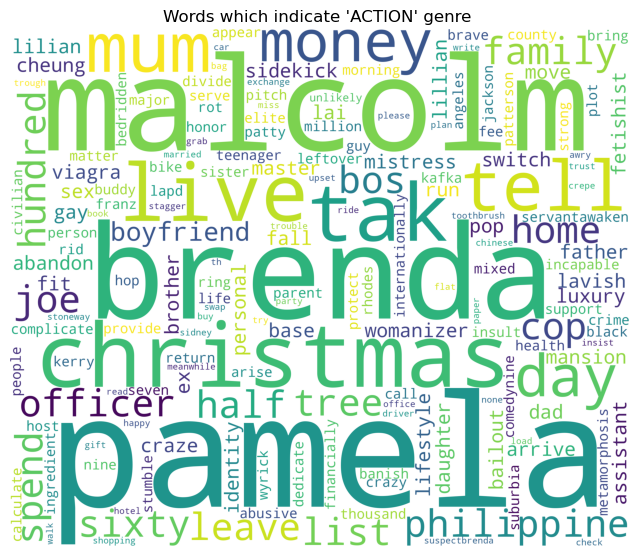

In [26]:
from wordcloud import WordCloud
wordcloud1 = WordCloud(background_color='white', width=3000, height=2500).generate(comedy)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title("Words which indicate 'ACTION' genre ")
plt.show()

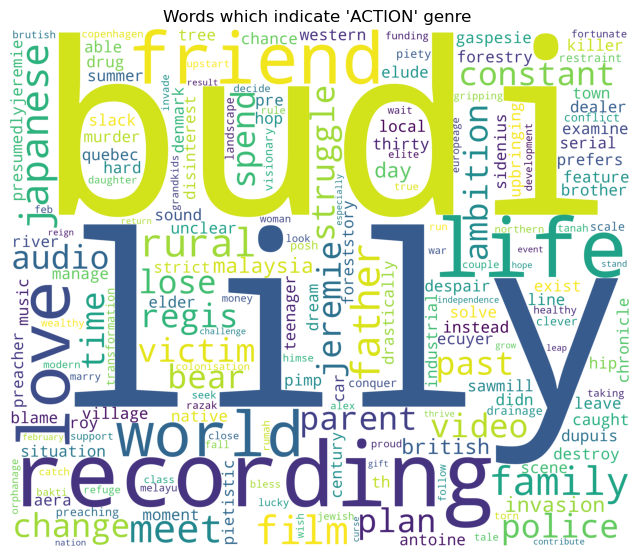

In [27]:
from wordcloud import WordCloud
wordcloud1 = WordCloud(background_color='white', width=3000, height=2500).generate(drama)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title("Words which indicate 'ACTION' genre ")
plt.show()

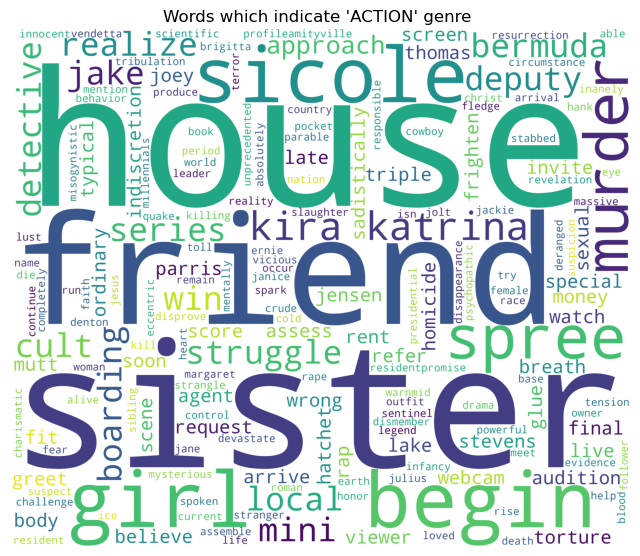

In [28]:
from wordcloud import WordCloud
wordcloud1 = WordCloud(background_color='white', width=3000, height=2500).generate(thriller)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title("Words which indicate 'ACTION' genre ")
plt.show()

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000, ngram_range=(1,2))
X = cv.fit_transform(corpus).toarray()
y = df['Genre'].values

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (4000, 5000), X_test size: (1000, 5000)


In [60]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [61]:
nb_y_pred = nb_classifier.predict(X_test)

In [62]:
from sklearn.metrics import accuracy_score
score1 = accuracy_score(y_test, nb_y_pred)
print("---- Score ----")
print("Accuracy score is: {}%".format(round(score1*100,2)))


---- Score ----
Accuracy score is: 71.8%


In [63]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
nb_cm = confusion_matrix(y_test, nb_y_pred)

In [48]:
nb_cm

array([[145,  16,  14,   8,  22],
       [  2, 172,   7,  11,   7],
       [ 18,  10, 121,  32,  13],
       [ 10,  25,  26, 124,  11],
       [ 10,  12,  10,  18, 156]], dtype=int64)

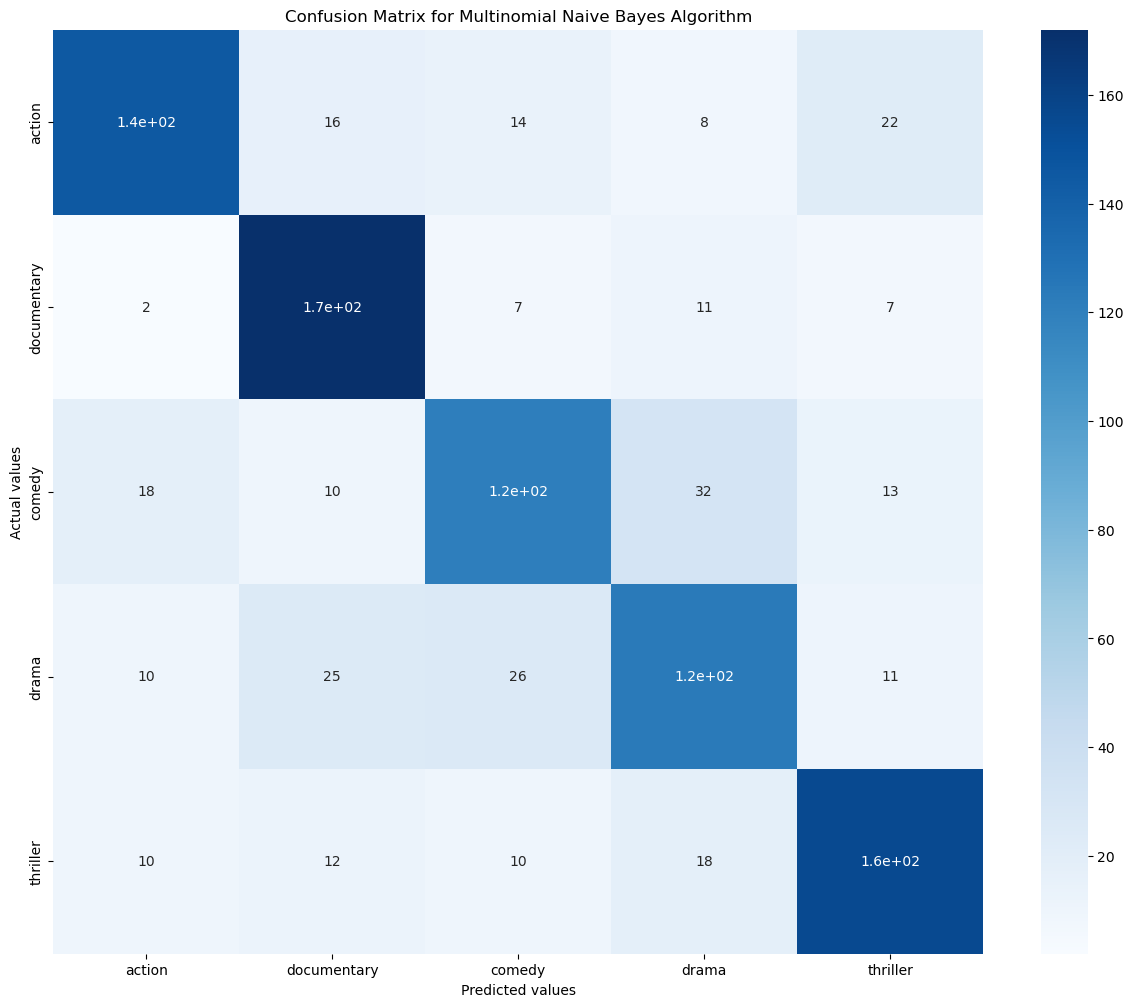

In [49]:
# Plotting the confusion matrix
plt.figure(figsize=(15,12))
axis_labels = ['action', 'documentary', 'comedy', 'drama', 'thriller']
sns.heatmap(data=nb_cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Multinomial Naive Bayes Algorithm')
plt.show()

In [ ]:
best_accuracy = 0.0
alpha_val = 0.0
for i in np.arange(0.1,1.1,0.1):
  temp_classifier = MultinomialNB(alpha=i)
  temp_classifier.fit(X_train, y_train)
  temp_y_pred = temp_classifier.predict(X_test)
  score = accuracy_score(y_test, temp_y_pred)
  print("Accuracy score for alpha={} is: {}%".format(round(i,1), round(score*100,2)))
  if score>best_accuracy:
    best_accuracy = score
    alpha_val = i
print('--------------------------------------------')
print('The best accuracy is {}% with alpha value as {}'.format(round(best_accuracy*100, 2), round(alpha_val,1)))

Accuracy score for alpha=0.1 is: 70.6%
Accuracy score for alpha=0.2 is: 71.3%
Accuracy score for alpha=0.3 is: 71.8%
Accuracy score for alpha=0.4 is: 72.2%
Accuracy score for alpha=0.5 is: 72.1%
Accuracy score for alpha=0.6 is: 72.2%
Accuracy score for alpha=0.7 is: 71.9%
Accuracy score for alpha=0.8 is: 71.8%
Accuracy score for alpha=0.9 is: 71.9%
Accuracy score for alpha=1.0 is: 71.8%
--------------------------------------------
The best accuracy is 72.2% with alpha value as 0.4


In [64]:
classifier = MultinomialNB(alpha=0.4)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.4)

In [ ]:
def genre_prediction(sample_script):
  sample_script = re.sub(pattern='[^a-zA-Z]',repl=' ', string=sample_script)
  sample_script = sample_script.lower()
  sample_script_words = sample_script.split()
  sample_script_words = [word for word in sample_script_words if not word in set(stopwords.words('english'))]
  ps = PorterStemmer()
  final_script = [ps.stem(word) for word in sample_script_words]
  final_script = ' '.join(final_script)

  temp = cv.transform([final_script]).toarray()
  return classifier.predict(temp)[0]

In [ ]:
'''def get_stop_words(stop_file_path, include_spanish=True):
    with open(stop_file_path, 'r', encoding='utf-8') as f:
        custom_stopwords = set(line.strip().lower() for line in f if line.strip())
    
    if include_spanish:
        spanish_stopwords = set(nltk_stopwords.words('spanish'))
        custom_stopwords.update(spanish_stopwords)
    
    return frozenset(custom_stopwords)

def clean_text(text):
    text = unidecode(text)                     # strip accents
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r"</?.*?>", " ", text)
    text = re.sub(r"(\d|\W|_)+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_text(text):
    return word_tokenize(text)

def get_wordnet_pos(treebank_tag):
    """Convert TreeBank POS tags to WordNet POS tags"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatize_with_pos(pos_tagged_tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    
    for word, tag in pos_tagged_tokens:
        pos = get_wordnet_pos(tag)  # You already have this function
        lemma = lemmatizer.lemmatize(word, pos)
        lemmas.append(lemma)

    return lemmas'''

In [ ]:
'''stopwords = get_stop_words("stopwords.txt", include_spanish=True)

# 🔹 3. Full processing pipeline function
def full_text_pipeline(text, stopwords):
    cleaned = clean_text(text)
    tokens = tokenize_text(cleaned)
    pos_tags = pos_tag(tokens)
    lemmas = lemmatize_with_pos(pos_tags)
    filtered = [lemma for lemma in lemmas if lemma not in stopwords]
    return filtered, ' '.join(filtered)

# 🔹 4. Apply to DataFrame
# Apply function and unpack results
df[['description_tokens', 'description_string']] = df['Description'].apply(
    lambda x: pd.Series(full_text_pipeline(x, stopwords))
)

description_tokens = df['description_tokens'].apply(len)
description_string = df['description_string']
df[['description_string']].to_csv('processed_descriptions.csv', index=False)'''

# BOW MODELLING

In [10]:
bow_vectorizer = CountVectorizer(max_df=0.16, max_features=5000)
description_bow_matrix = bow_vectorizer.fit_transform(description_string.tolist())

In [11]:
x_bow = description_bow_matrix
y = df["Genre"].values

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded_BOW = label_encoder.fit_transform(y)

In [13]:
x_train_BOW, x_test_BOW, y_train, y_test = train_test_split(x_bow, y_encoded_BOW, test_size=0.3, random_state=42)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train_BOW, y_train)
y_pred_log = log_reg.predict(x_test_BOW)

print("🔵 Logistic Regression Report")
print(classification_report(y_test, y_pred_log, target_names=label_encoder.classes_))
f1_log = f1_score(y_test, y_pred_log, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_log:.4f}")

🔵 Logistic Regression Report
              precision    recall  f1-score   support

      action       0.73      0.70      0.71       316
      comedy       0.59      0.59      0.59       309
 documentary       0.73      0.80      0.76       284
       drama       0.55      0.56      0.56       301
    thriller       0.73      0.69      0.71       290

    accuracy                           0.67      1500
   macro avg       0.67      0.67      0.67      1500
weighted avg       0.67      0.67      0.66      1500

🎯 Weighted F1 Score: 0.6650


c:\Users\Admin\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Admin\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
c:\Users\Admin\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Admin\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


KeyError: 'genre'

In [ ]:
# Step 1 — Load new test data
test_df = pd.read_csv('AA_movie_comp_template.csv')

# Step 2 — Do your transformations

# X = ... # your transformed input
# y = ... # your transformed labels
# best_model = ... # your model


# Step 3 — Predict
y_pred = best_model.predict(X)

# Step 4 — Evaluate accuracy

from sklearn.metrics import classification_report

print(classification_report(y, y_pred))
